# Week 4: Implementing RBF Networks, Regularized Regression

# Lecture 6: A Gradient-based RBF Network Implementation

In class, we saw that radial basis function networks model unknown functions as

$$\hat{f}(x_i)=\theta_0 + \sum\limits_{j=1}^M K_{\lambda_j}(\xi_j,x_i)\theta_j=X_K\theta$$

where $K$ is some function dependent on the distance between points $\xi_j$ and $x$, but is not otherwise dependent on those variables. The most common is the Gaussian kernel,

$$K_{\lambda_j}(\xi_j,x_i) = \exp\left(-\frac{\|\xi_j-x_i\|^2}{2\lambda_j^2}\right)$$

and

$$X_K=\begin{pmatrix}
1 & K_{\lambda_1}(\xi_1, x_1) & \cdots & K_{\lambda_M}(\xi_M, x_1)\\
1 & K_{\lambda_1}(\xi_1, x_2) & \cdots & K_{\lambda_M}(\xi_M, x_2)\\
\vdots & \vdots & \ddots & \vdots\\
1 & K_{\lambda_1}(\xi_1, x_n) & \cdots & K_{\lambda_M}(\xi_M, x_n)
\end{pmatrix}$$

and $\theta=(\theta_0, \theta_1, ..., \theta_M)$.

We will try to fit the model to the training data $(x_1,y_1), (x_2, y_2), ..., (x_n, y_n)$, where each point is in $d$-dimensional space: $x_i\in\mathbb{R}^d$. The parameter has parameters $\lambda_j$, $\theta_j$, $\xi_j$ for $j=1, 2, ..., M$ and $\theta_0$, noting each $\xi_j$ has the same dimension as each $x_i$.

A good approach to Fitting the model is to minimize the sum of squared error loss function,

$$L(\theta,\lambda,\xi)=\|X_K\theta - y\|^2$$

where $y=(y_1, y_2, ..., y_n)$ That is, to solve the problem

$$\min\limits_{\theta, \lambda, \xi}L(\theta,\lambda,\xi)$$

It turns out, this problem is not particularly easy for a few reasons:

* $L$ is non-convex and does not have a unique minimum. There are multiple local minima, so it is difficult to know if we have found the global minimum.
* $L$ depends on $M+1$ variables $\theta_j$, $M$ variables $\lambda_j$, and $M$ $d$-dimensional variables $\xi_j$, which makes many variables with respect to which we need to minimize.

Unlike the previous methods we have learned, finding critical values of the loss function $L$ is not easy enough to do by hand, so we will rely on algorithms like gradient descent for this purpose.

In addition, approximating gradients $\nabla L$ with the `computeGradient` function will be incredibly expensive since we would need to evaluate $L$ with a small perturbation in each of the $(2+d)M+1$ components of the input to $L$ to get all the partial derivatives in *each* iteration of gradient descent.

This is infeasible, so we will derive a closed-form formula for the exact gradient $\nabla L$ that can be implemented instead of requiring all of these evaluations of $L$. Please see the details in the lecture video, but we found the following partial derivatives.

$$\begin{align}
&\frac{\partial L(\theta,\lambda,\xi)}{\partial \theta_0}=2\sum\limits_{i=1}^n\left(\hat{f}(x_i)-y_i\right)\\
&\frac{\partial L(\theta,\lambda,\xi)}{\partial \theta_k}=2\sum\limits_{i=1}^n\left(\hat{f}(x_i)-y_i\right)K_{\lambda_k}(\xi_k,x_i), &&k=1, 2, ..., M\\
&\frac{\partial L(\theta,\lambda,\xi)}{\partial \theta_k}=2\frac{\theta_k}{\lambda_k}\sum\limits_{i=1}^n\left(\hat{f}(x_i)-y_i\right)K_{\lambda_k}(\xi_k,x_i)\left(\frac{\|\xi_k-x_i\|^2}{\lambda_k^2}-1\right), &&k=1, 2, ..., M\\
&\frac{\partial L(\theta,\lambda,\xi)}{\partial \xi_{kl}}=2\frac{\theta_k}{\lambda_k^2}\sum\limits_{i=1}^n\left(\hat{f}(x_i)-y_i\right)K_{\lambda_k}(\xi_k,x_i)(x_{il}-\xi_{kl}), &&k=1, 2, ..., M\text{ and }l=1, ..., d
\end{align}
$$

Note that the derivatives all have the $(\hat{f}(x_i)-y_i)$ term and some share the $K_{\lambda_k}(\xi_k,x_i)$ term, so an effective implementation that computes these partial derivatives will reuse the calculations rather than redoing them so many times.

It should be noted the coefficient 2 of each of these may be dropped because we will be taking steps proportional to the gradient $\nabla L$ with a learning rate we can control, so it is redundant and we omit it from the code.

## Implementing Gaussian RBF Networks

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
# create a RBF network class
class GaussianRBFnetwork:
    # initialize the model
    def __init__(self, d, M, alpha = 0.001, initialization = 'uniform'):
        # the dimension of the datapoints
        self.d = d
        
        # the number of radial basis functions
        self.M = M
                
        # the learning rate
        self.alpha = alpha
        
        # initialize the parameters
        if initialization == 'uniform':
            theta = 10 * np.random.uniform(-1, 1, size = (M + 1))
            lam = 10 * np.random.uniform(0, 1, size = (M))
            xi = 10 * np.random.uniform(-1, 1, size = (M, d))

        # save the initial parameters
        self.theta = theta
        self.lam = lam
        self.xi = xi
                
    # fit the model to some data X with labels y
    def fit(self, X, y, epochs = 1000, update = 10, annealing = False):
        self.n = X.shape[0]
        
        # save the training data
        self.input = np.hstack((np.ones([self.n, 1]), X))
        
        # save the training labels
        self.output = y
        
        # initialize the kernel-weighted inputs
        XK = np.zeros([self.n, self.M])
        XK = np.hstack((np.ones([self.n, 1]), XK))
        
        # save the learning rate locally
        alpha = copy.copy(self.alpha)
        
        # run gradient descent with exact gradient
        # pre-compute terms
        for j in range(epochs):
            # compute the kernel-weighted inputs
            for i in range(self.n):
                for k in range(self.M):
                    XK[i, k + 1] = self.GaussianKernel(self.input[i, 1:], self.xi[k], self.lam[k])
                        
            # training predictions
            predictions = XK @ self.theta
            
            # compute the error
            error = predictions - self.output

            # compute the weighted error
            weightederror = np.atleast_2d(error).T * XK
            
            # compute the theta partial derivatives
            thetagrad = np.sum(weightederror, axis = 0)
            
            # compute the lambda partial derivatives
            term3 = np.zeros([self.n, self.M])
            for k in range(self.M):
                term3[:, k] = ((np.linalg.norm(self.xi[k] - self.input[:,1:], axis = 1)/self.lam[k]) ** 2 - 1) * self.theta[k]/self.lam[k]
            
            lamerror = term3 * weightederror[:, 1:]
            lamgrad = np.sum(lamerror, axis = 0)

            # compute the xi partial derivatives
            term4 = np.zeros([self.n, self.M, self.d])
            for k in range(self.M):
                for l in range(self.d):
                    term4[:, k, l] = (self.input[:, l] - self.xi[k, l]) * self.theta[k] / self.lam[k] ** 2

            xierror = term4 * np.atleast_3d(weightederror[:, 1:])
            xigrad = np.sum(xierror, axis = 0)
            
            # weight update
            self.theta -= self.alpha * thetagrad
            self.lam -= self.alpha * lamgrad
            self.xi -= self.alpha * xigrad

            # ensure lambdas are positive
            self.lam = np.abs(self.lam)
                        
            # if the annealing variable is True, shrink the learning rate over time
            if annealing:
                self.alpha = (1 - j / epochs) * alpha
                
            # print a status update periodically
            if j % update == 0:
                print('Epoch', j, '\tLoss =', np.sum(error ** 2)/self.M)

    # compute predictions
    def predict(self, X):
        n = X.shape[0]
        X = np.hstack((np.ones([n, 1]), X))
        
        # initialize the kernel-weighted inputs
        XK = np.zeros([n, self.M])
        XK = np.hstack((np.ones([n, 1]), XK))
        
        # compute the kernel-weighted inputs
        for i in range(n):
            for k in range(self.M):
                XK[i, k + 1] = self.GaussianKernel(X[i, 1:], self.xi[k], self.lam[k])
                
        # training predictions
        predictions = XK @ self.theta

        return predictions
    
    # the Gaussian radial basis function
    def GaussianKernel(self, x, xi, lam):
        return (1/lam) * np.exp(-np.linalg.norm(x - xi) ** 2 / (2 * lam ** 2))

### Example: Tiny Dataset

Epoch 0 	Loss = 59.939986830503855
Epoch 5000 	Loss = 0.04939586295404132
Epoch 10000 	Loss = 0.045996754169380163
The mean absolute error on the training set is 0.1625752684753517


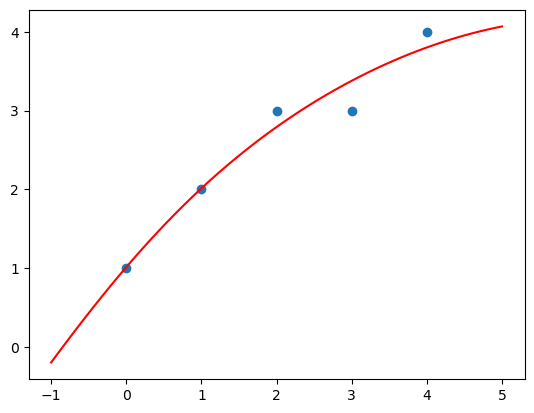

In [3]:
model = GaussianRBFnetwork(d = 1, M = 5, alpha = 0.05, initialization = 'uniform')

X = np.array([[0], [1], [2], [3], [4]])
Y = np.array([1, 2, 3, 3, 4])

model.fit(X, Y, epochs = 15000, update = 5000, annealing = False)

# predict the outputs
predictions = model.predict(X)

# compute the training and test mean absolute error
trainError = mean_absolute_error(Y, predictions)

# return quality metrics
print('The mean absolute error on the training set is', trainError)

xModel = np.linspace(X[0] - 1, X[-1] + 1, 100)
yModel = model.predict(xModel)

plt.scatter(X, Y)

plt.plot(xModel, yModel, 'r')

We get a nice fit here. Similar to kernel smoothing, a larger $M$ will result in smaller loss, but may not generalize well. Further, there is an intermediate value of the learning rate $\alpha$ that will be most effective--too large and it will not find a good minimum, too small and it will take too long to converge.

If we run the code multiple times, we will usually land in different local minima due to the random initialization and existence of multiple local minima where gradient descent can get stuck.

### Example: Shampoo Dataset

In [4]:
# read the shampoo sales dataset
data = pd.read_csv('../data/shampoo.csv')

# save the targets
Y = data['Sales'].to_numpy()

# make a column vector of 0s with n elements
X = np.zeros([Y.shape[0], 1])

# convert the vector to (0, 1, 2, ..., n)
X[:,0] = [i for i in range(Y.shape[0])]

#X = scale(X)

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

Epoch 0 	Loss = 142013.1495160939
Epoch 1000 	Loss = 14708.315135236666
Epoch 2000 	Loss = 11988.217154812224
Epoch 3000 	Loss = 10425.104332065093
Epoch 4000 	Loss = 9350.797541077636
Epoch 5000 	Loss = 9245.25884501607
Epoch 6000 	Loss = 8767.688297829127
Epoch 7000 	Loss = 8462.303497747187
Epoch 8000 	Loss = 10148.982038854254
Epoch 9000 	Loss = 8665.105720829455
The r^2 score is 0.685578691159587
The mean absolute error on the training set is 62.27225175998699
The mean absolute error on the testing set is 52.883149792376564


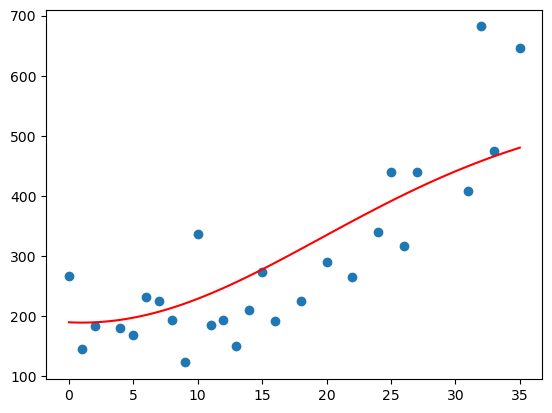

In [5]:
model = GaussianRBFnetwork(d = 1, M = 20, alpha = 0.01)

model.fit(trainX, trainY, epochs = 10000, update = 1000, annealing = False)

# predict the outputs
trainPredictions = model.predict(trainX)

# plot the training points
plt.scatter(trainX, trainY, label = 'Training Data')

# plot the fitted model with the training data
xModel = np.atleast_2d(np.linspace(X[0][0],X[-1][0],100)).T

# compute the predicted curve
yModel = model.predict(xModel)

plt.plot(xModel, yModel, 'r')

testPredictions = model.predict(testX)

# compute the training and test mean absolute error
trainError = mean_absolute_error(trainY, trainPredictions)
testError = mean_absolute_error(testY, testPredictions)
    
# return quality metrics
print('The r^2 score is', r2_score(trainY, trainPredictions))
print('The mean absolute error on the training set is', trainError)
print('The mean absolute error on the testing set is', testError)

Again, a nice curved plot to fit the data.

# Lecture 12: Regularization and Overfitting

The problem of **overfitting** is an issue where a machine learning model fits too strongly to the training data, which reduces its ability to generalize to make good predictions on the test set. High performance on the test set is typically our most important goal, because this measures how the model performs on data it has not seen before, indicating the model should perform well on real-world data, assuming the test data are representative of the data we hope to predict.

Below, we implement ridge regression, which imposes an $L^2$ penalty on the model parameters to minimize the loss function

$$L(\theta) = \|X\theta - y\|^2 + \lambda_2\|\theta\|^2$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [2]:
class RidgeRegression:
    
    def __init__(self, alpha = 0.001, lambda2 = 0):
        # save variables to object memory
        self.alpha = alpha
        self.lambda2 = lambda2
        
    # fit the model to the data
    def fit(self, X, y, epochs = 1000, update = 100):
        # find the dimension of the data
        d = X.shape[1]
        
        # initialize the model parameters
        self.theta0 = np.random.uniform()
        self.theta = np.random.uniform(size = d)
        
        # compute the means of X and y
        yMean = np.mean(y)
        xMean = np.mean(X, axis = 0)
        
        # standardize the data
        X = scale(X)
        y = scale(y)
        
        # compute a scaling parameter
        eta = np.linalg.norm(X)
        
        # train the model
        for i in range(epochs):
            # compute the predicted y values
            predictions = self.theta0 + X @ self.theta
            
            # compute the error
            error = predictions - y
            
            # compute the sum of squared errors
            sse = np.sum(error ** 2)
            
            # compute the loss
            loss = sse + self.lambda2 * np.linalg.norm(self.theta) ** 2 #+ self.lambda1 * np.sum(np.abs(self.theta))

            # print an update
            if (i + 1) % update == 0:
                print('Epoch', i + 1, '\tLoss', loss)
                                                
            # weight update for the bias
            self.theta -= self.alpha * (X.T @ error + 2 * self.lambda2 * self.theta)
            self.theta0 = yMean - xMean @ self.theta

    # predict the output from input (testing) data
    def predict(self, X):
        # return the predicted outputs
        return self.theta0 + X @ self.theta

Let's test it on a small, simple dataset to check that it works.

Epoch 10 	Loss 30.99233886905759
Epoch 20 	Loss 15.963356371329532
Epoch 30 	Loss 8.326949445389527
Epoch 40 	Loss 4.8280371062671446
Epoch 50 	Loss 3.575931351589637
Epoch 60 	Loss 3.4863419976443106
Epoch 70 	Loss 3.9486373509603365
Epoch 80 	Loss 4.628068093393975
Epoch 90 	Loss 5.348714105108488
Epoch 100 	Loss 6.024602447060918
The predicted y values are [2.12829514 2.36414757 2.6        2.83585243 3.07170486]
The real y values are [1 2 3 3 4]
The theta values are [0.71318057 0.23585243]
The r^2 score is 0.5280135239321685
The mean squared error is 0.4908659351105449
The mean absolute error is 0.5969770850578974


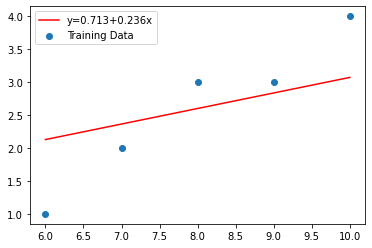

In [3]:
X = np.array([[6], [7], [8], [9], [10]])
y = np.array([1, 2, 3, 3, 4])

model = RidgeRegression(lambda2 = 10)
model.fit(X, y, epochs = 100, update = 10)
predictions = model.predict(X)

# print the predictions
print('The predicted y values are', predictions)

# print the real y values
print('The real y values are', y)

# print the beta values
parameters = np.concatenate((np.atleast_1d(model.theta0), model.theta))
print('The theta values are', parameters)

# plot the training points
plt.scatter(X, y, label = 'Training Data')

# plot the fitted model with the training data
xModel = np.linspace(6,10,100)
yModel = parameters[0] + parameters[1]*xModel
lineFormula = 'y={:.3f}+{:.3f}x'.format(parameters[0], parameters[1])
plt.plot(xModel, yModel, 'r', label = lineFormula)

# add a legend
plt.legend()

# return quality metrics
print('The r^2 score is', r2_score(y, predictions))
print('The mean squared error is', mean_squared_error(y, predictions))
print('The mean absolute error is', mean_absolute_error(y, predictions))

# Lecture 7: Crash Course in Probability and Statistics

See the notes in Canvas. There is no code for this lecture.